# Modelo de predicción de series de tiempo para la velocidad y dirección del viento usando N-HiTS.

En el presente proyecto se demuestra el desempeño en la predicción de series de tiempo a largo plazo de un nuevo modelo llamado N-HiTS, presentado por Challu et. al. en el año 2022. Dicho modelo aborda dos de los retos actuales más considerables de las predicciones de series de tiempo con modelos neuronales, los cuales son la volatibilidad de las predicciones y su complejidad computacional. De acuerdo con Challu et. al. (2022), el modelo N-HiTS da una solución eficiente a dichos retos gracias a la incorporación de interpolación jerárquica y de técnicas de muestreo de datos de índice multiple, ofreciendo una mejora del 25% en la precisión de las predicciones a la vez que se redujo en una décima parte el tiempo de procesamiento computacional en comparación con los modelos más utilizados en la actualidad. En este proyecto se comparará el desempeño de las redes neuronales recurrentes con arquitectura LSTM con N-HiTS. 

### Series de tiempo del clima

Los datos utilizados para este proyecto fueron recopilados por el Instituto Max Planck de Biogeoquímica y consta de las series de tiempo del clima en la ciudad de Jena, Alemania, desde enero del 2009 a diciembre del 2016. Algunas de las variables atmosféricas registradas en los datos son temperatura, presión atmosférica, humedad, etc., los cuales se detallan más adelante. El registro de los datos fue realizado cada 10 minutos.

__Ubicación__: Estación del clima, [Instituto Max Planck de Biogeoquímica](https://www.bgc-jena.mpg.de/wetter/) en Jena, Alemania.

__Espacio de tiempo considerado__: 10 de enero del 2009 - 31 de diciembre del 2016.

La siguiente tabla contiene una descripción detallada del set de datos utilizados:

| Índice | Variable        | Formato             | Descripción                                                                                                                                                                                                                                        |
|:--------|:-----------------|:---------------------|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| 1      | Date Time       | 01.01.2009 00:10:00 | Fecha y hora del registro                                                                                                                                                                                                                          |
| 2      | p (mbar)        | 996.52              | La unidad de presión derivada del SI pascal utilizada para cuantificar la presión interna. Los informes meteorológicos suelen indicar la presión atmosférica en milibares.                                                                         |
| 3      | T (degC)        | -8.02               | Temperatura en grados Celsius                                                                                                                                                                                                                      |
| 4      | Tpot (K)        | 265.4               | Temperatura en grados Kelvin                                                                                                                                                                                                                       |
| 5      | Tdew (degC)     | -8.9                | Temperatura en Celsius relativa a la humedad. El punto de rocío. o Dew Point (DW) es una medida de la cantidad absoluta de agua en el aire, el DP es la temperatura a la que el aire no puede retener toda la humedad en él y el agua se condensa. |
| 6      | rh (%)          | 93.3                | La humedad relativa (RH) es una medida de cuán saturado está el aire con vapor de agua, el % de RH determina la cantidad de agua contenida dentro de los objetos de recolección.                                                                   |
| 7      | VPmax (mbar)    | 3.33                | Presión de vapor saturado                                                                                                                                                                                                                          |
| 8      | VPact (mbar)    | 3.11                | Presión de vapor                                                                                                                                                                                                                                   |
| 9      | VPdef (mbar)    | 0.22                | Déficit de presión de vapor                                                                                                                                                                                                                        |
|        |                 |                     |                                                                                                                                                                                                                                                    |
| 10     | sh (g/kg)       | 1.94                | Humedad específica                                                                                                                                                                                                                                 |
| 11     | H2OC (mmol/mol) | 3.12                | Concentración de vapor de agua                                                                                                                                                                                                                     |
| 12     | rho (g/m ** 3)  | 1307.75             | Densidad del aire                                                                                                                                                                                                                                  |
| 13     | wv (m/s)        | 1.03                | Velocidad del viento                                                                                                                                                                                                                               |
| 14     | max. wv (m/s)   | 1.75                | Velocidad máxima del viento                                                                                                                                                                                                                        |
| 15     | wd (deg)        | 152.3               | Dirección del viento en grados

## 1. Importación de datos

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from heatmap import heatmap, corrplot
import tensorflow as tf
from tensorflow import keras

In [2]:
df = pd.read_csv('jena_climate_2009_2016.csv', parse_dates = True, index_col = 'Date Time')
df

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
2016-12-31 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
2016-12-31 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 420551 entries, 2009-01-01 00:10:00 to 2017-01-01 00:00:00
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   p (mbar)         420551 non-null  float64
 1   T (degC)         420551 non-null  float64
 2   Tpot (K)         420551 non-null  float64
 3   Tdew (degC)      420551 non-null  float64
 4   rh (%)           420551 non-null  float64
 5   VPmax (mbar)     420551 non-null  float64
 6   VPact (mbar)     420551 non-null  float64
 7   VPdef (mbar)     420551 non-null  float64
 8   sh (g/kg)        420551 non-null  float64
 9   H2OC (mmol/mol)  420551 non-null  float64
 10  rho (g/m**3)     420551 non-null  float64
 11  wv (m/s)         420551 non-null  float64
 12  max. wv (m/s)    420551 non-null  float64
 13  wd (deg)         420551 non-null  float64
dtypes: float64(14)
memory usage: 48.1 MB


In [4]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),420551.0,989.212776,8.358481,913.60,984.20,989.58,994.72,1015.35
T (degC),420551.0,9.450147,8.423365,-23.01,3.36,9.42,15.47,37.28
Tpot (K),420551.0,283.492743,8.504471,250.60,277.43,283.47,289.53,311.34
Tdew (degC),420551.0,4.955854,6.730674,-25.01,0.24,5.22,10.07,23.11
rh (%),420551.0,76.008259,16.476175,12.95,65.21,79.30,89.40,100.00
VPmax (mbar),420551.0,13.576251,7.739020,0.95,7.78,11.82,17.60,63.77
VPact (mbar),420551.0,9.533756,4.184164,0.79,6.21,8.86,12.35,28.32
VPdef (mbar),420551.0,4.042412,4.896851,0.00,0.87,2.19,5.30,46.01
sh (g/kg),420551.0,6.022408,2.656139,0.50,3.92,5.59,7.80,18.13
H2OC (mmol/mol),420551.0,9.640223,4.235395,0.80,6.29,8.96,12.49,28.82


De acuerdo a lo observado, no hay datos nulos y todos los datos parecen tener valores veraces y certeros, con excepción de la velocidad del viento y la velocidad máxima del viento, pues se aprecia que el valor mínimo de ambos datos es de -9999. Esto no puede ser posible, ya que los sensores miden la rapidez y por lo tanto los valores no pueden ser negativos. Además, una rápidez de 9999 m/s está muy fuera del rango de los valores positivos presentados, los cuales tienen un máximo de 28.49 m/s. En seguida se revisa este problema más a detalle.

In [5]:
df[df['wv (m/s)'] < 0]

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2015-07-13 09:10:00,990.49,16.85,290.80,12.78,76.90,19.22,14.78,4.44,9.34,14.92,1183.06,-9999.0,-9999.0,359.7
2015-07-13 09:20:00,990.32,17.06,291.03,12.86,76.30,19.48,14.86,4.62,9.39,15.01,1181.97,-9999.0,-9999.0,359.8
2015-07-13 09:30:00,990.24,17.43,291.41,12.75,74.00,19.94,14.76,5.19,9.32,14.90,1180.42,-9999.0,-9999.0,359.8
2015-07-13 09:40:00,990.27,17.71,291.68,12.88,73.30,20.30,14.88,5.42,9.40,15.02,1179.26,-9999.0,-9999.0,359.8
2015-07-13 09:50:00,990.28,17.76,291.73,13.03,73.80,20.36,15.03,5.33,9.49,15.17,1179.00,-9999.0,-9999.0,359.8
2015-07-13 10:00:00,990.20,17.98,291.96,12.74,71.40,20.65,14.74,5.90,9.31,14.89,1178.14,-9999.0,-9999.0,359.8
2015-07-13 10:10:00,990.17,18.19,292.17,12.59,69.78,20.92,14.60,6.32,9.22,14.74,1177.32,-9999.0,-9999.0,359.8
2015-07-13 10:20:00,990.07,18.31,292.30,12.97,71.00,21.08,14.97,6.11,9.46,15.12,1176.55,-9999.0,-9999.0,359.8
2015-07-13 10:30:00,990.02,18.24,292.24,12.88,70.90,20.99,14.88,6.11,9.40,15.03,1176.82,-9999.0,-9999.0,359.8


In [6]:
df[df['max. wv (m/s)'] < 0]

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2015-07-13 09:00:00,990.52,16.98,290.93,12.94,77.10,19.38,14.94,4.44,9.44,15.09,1182.50,6.16,-9999.0,289.6
2015-07-13 09:10:00,990.49,16.85,290.80,12.78,76.90,19.22,14.78,4.44,9.34,14.92,1183.06,-9999.00,-9999.0,359.7
2015-07-13 09:20:00,990.32,17.06,291.03,12.86,76.30,19.48,14.86,4.62,9.39,15.01,1181.97,-9999.00,-9999.0,359.8
2015-07-13 09:30:00,990.24,17.43,291.41,12.75,74.00,19.94,14.76,5.19,9.32,14.90,1180.42,-9999.00,-9999.0,359.8
2015-07-13 09:40:00,990.27,17.71,291.68,12.88,73.30,20.30,14.88,5.42,9.40,15.02,1179.26,-9999.00,-9999.0,359.8
2015-07-13 09:50:00,990.28,17.76,291.73,13.03,73.80,20.36,15.03,5.33,9.49,15.17,1179.00,-9999.00,-9999.0,359.8
2015-07-13 10:00:00,990.20,17.98,291.96,12.74,71.40,20.65,14.74,5.90,9.31,14.89,1178.14,-9999.00,-9999.0,359.8
2015-07-13 10:10:00,990.17,18.19,292.17,12.59,69.78,20.92,14.60,6.32,9.22,14.74,1177.32,-9999.00,-9999.0,359.8
2015-07-13 10:20:00,990.07,18.31,292.30,12.97,71.00,21.08,14.97,6.11,9.46,15.12,1176.55,-9999.00,-9999.0,359.8


Al parecer hubo una falla en los sensores el día 13 de julio del 2015 entre las 9 de la mañana y las 12 del medio día, pues todos los registros de la velocidad del viento y la velocidad máxima del viento tienen un valor de -9999. Además, se aprecia que justo al inicio y al final de los datos erroneos, los valores de la velocidad son mucho más altos de la media, por lo que éstos también serán sustuidos por la media. Antes de proseguir con las visualizaciones de las series de tiempo, estos datos erroneos se sustituirán por la media correspondiente.

In [7]:
df.loc[df['wv (m/s)'] < 0, 'wv (m/s)'] = df['wv (m/s)'].mean()
df.loc[df['max. wv (m/s)'] < 0, 'max. wv (m/s)'] = df['max. wv (m/s)'].mean()
df.loc[df['wv (m/s)'] > df['max. wv (m/s)'], 'wv (m/s)'] = df['wv (m/s)'].mean()

df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),420551.0,989.212776,8.358481,913.60,984.20,989.58,994.72,1015.35
T (degC),420551.0,9.450147,8.423365,-23.01,3.36,9.42,15.47,37.28
Tpot (K),420551.0,283.492743,8.504471,250.60,277.43,283.47,289.53,311.34
Tdew (degC),420551.0,4.955854,6.730674,-25.01,0.24,5.22,10.07,23.11
rh (%),420551.0,76.008259,16.476175,12.95,65.21,79.30,89.40,100.00
VPmax (mbar),420551.0,13.576251,7.739020,0.95,7.78,11.82,17.60,63.77
VPact (mbar),420551.0,9.533756,4.184164,0.79,6.21,8.86,12.35,28.32
VPdef (mbar),420551.0,4.042412,4.896851,0.00,0.87,2.19,5.30,46.01
sh (g/kg),420551.0,6.022408,2.656139,0.50,3.92,5.59,7.80,18.13
H2OC (mmol/mol),420551.0,9.640223,4.235395,0.80,6.29,8.96,12.49,28.82


## 2. Visualización de datos

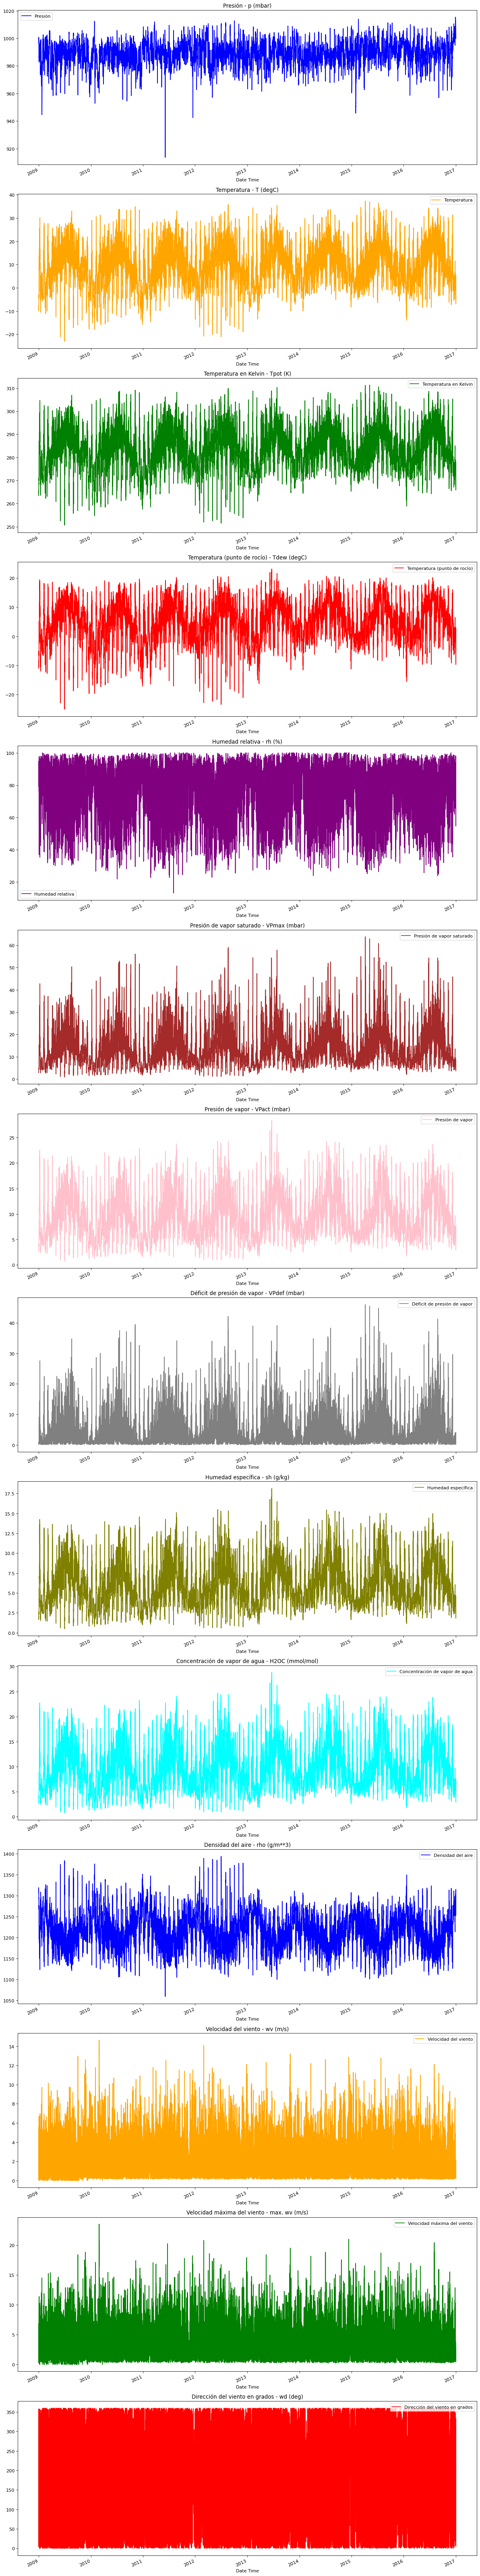

In [9]:
titles = [
    'Presión', 
    'Temperatura', 
    'Temperatura en Kelvin',
    'Temperatura (punto de rocío)',
    'Humedad relativa',
    'Presión de vapor saturado',
    'Presión de vapor',
    'Déficit de presión de vapor',
    'Humedad específica',
    'Concentración de vapor de agua',
    'Densidad del aire',
    'Velocidad del viento',
    'Velocidad máxima del viento',
    'Dirección del viento en grados'
]

feature_keys = [
    'p (mbar)',
    'T (degC)',
    'Tpot (K)',
    'Tdew (degC)',
    'rh (%)',
    'VPmax (mbar)',
    'VPact (mbar)',
    'VPdef (mbar)',
    'sh (g/kg)',
    'H2OC (mmol/mol)',
    'rho (g/m**3)',
    'wv (m/s)',
    'max. wv (m/s)',
    'wd (deg)'
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]


def show_visualization(data):
    time_data = data.index
    fig, axes = plt.subplots(
        nrows=14, ncols=1, figsize=(15, 80), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i],
            color=c,
            title=f'{titles[i]} - {key}',
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_visualization(df)

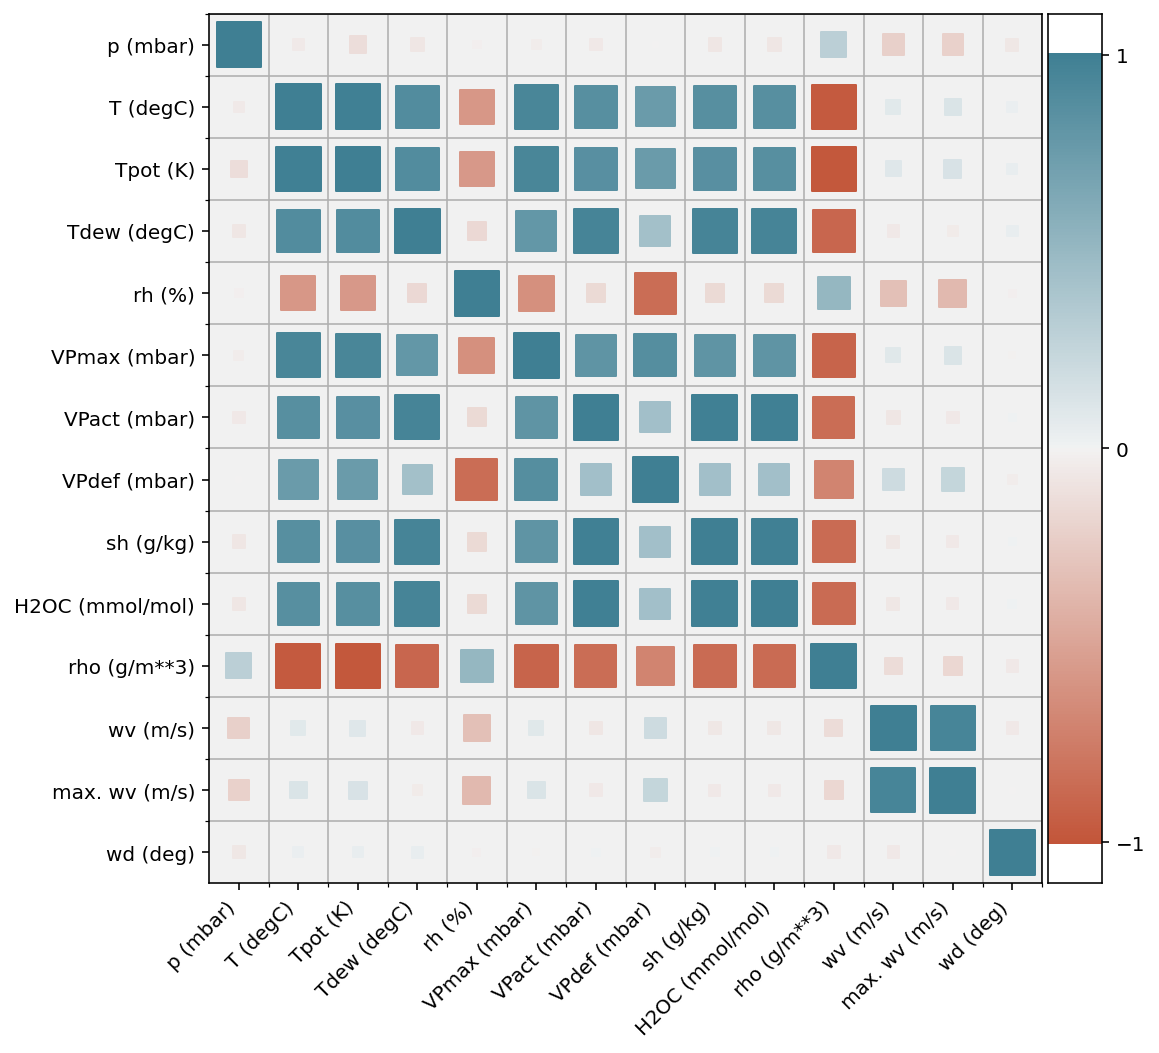

In [68]:
plt.figure(figsize=(8, 8))
corrplot(df.corr(), size_scale=500)

## 3. Procesamiento de datos